<a href="https://colab.research.google.com/github/diwakar-vsingh/swift-models/blob/master/deepLab/S4TFdeepLabV3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLabV3+ in Swift for TensorFlow (S4TF)

## Setup Program

### Import Standard Swift Libraries

In [ ]:
import TensorFlow
import Python
import PythonKit
import Foundation
import FoundationNetworking
import Path
import Just

2020-11-29 22:23:30.195246: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


### Import Python Libraries

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let subprocess = Python.import("subprocess")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let tf = Python.import("tensorflow")
let os = Python.import("os")
let shutil = Python.import("shutil")

2020-11-29 22:23:38.404057: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
extension String {
  func replacingFirstOccurrence(of target: String, with replacement: String) -> String {
    guard let range = self.range(of: target) else { return self }
    return self.replacingCharacters(in: range, with: replacement)
  }
}

## Import Model Weights

In [ ]:
func get_xception_filename(_ key: PythonObject) -> String {
  // Rename tensor name to the corresponding Keras layer weight name.
  // Arguments
  //   key: tensor name in TF (determined by tf.variable_scope)
  
  var filename = String(key)!
  filename = filename.replacingOccurrences(of: "/", with: "_")
  filename = filename.replacingOccurrences(of: "xception_65_", with: "")
  filename = filename.replacingFirstOccurrence(of: "decoder_", with: "")
  filename = filename.replacingOccurrences(of: "BatchNorm", with: "BN")
  
  if filename.contains("Momentum"){return "None"}
  
  if filename.contains("entry_flow") || filename.contains("exit_flow") {
    filename = filename.replacingOccurrences(of: "_unit_1_xception_module", with: "")
  } else if filename.contains("middle_flow") {
    filename = filename.replacingOccurrences(of: "_block1", with: "")
    filename = filename.replacingOccurrences(of: "_xception_module", with: "")
  }
    
  // from TF to Keras naming
  filename = filename.replacingOccurrences(of: "_weights", with: "_kernel")
  filename = filename.replacingOccurrences(of: "_biases", with: "_bias")

  return filename
}

func extract_tensors_from_checkpoint_file(
  fileName: String, outputFolder: String = "weights") -> [String] {
    // Extract tensors from a TF checkpoint file.
    // Arguments:
    //  - fileName: TF checkpoint file
    //  - outputFolder: where to save the output numpy array files
    
    if ~os.path.exists(outputFolder) == -1 {
      os.makedirs(outputFolder)
    }
      
    let reader: PythonObject = tf.compat.v1.train.NewCheckpointReader(fileName)
    var fName: String
    var layerName: [String] = []

    for key in reader.get_variable_to_shape_map() {
      // convert tensor name into the corresponding Keras layer weight name and save
      fName = get_xception_filename(key)
            
      if fName != "None" { 
        let path = os.path.join(outputFolder, fName)
        let arr = reader.get_tensor(key)
        layerName.append(fName)
        np.save(path, arr)
        }
      }
    return layerName
  }

In [ ]:
let CKPT_URL = "http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz"
let MODEL_DIR = "models"

if ~os.path.exists(MODEL_DIR) == -1 {
  os.makedirs(MODEL_DIR)
}

let checkpoint_tar = tf.keras.utils.get_file(
    fname: "deeplabv3_pascal_trainval_2018_01_04.tar.gz",
    origin: CKPT_URL,
    extract: Python.True,
    cache_subdir: "",
    cache_dir: MODEL_DIR)

let output_folder = "weights/xception"
let net_name = "xception"

let MODEL_SUBDIR = "deeplabv3_pascal_trainval"
let MODEL_SUBDIR_MOBILE = "deeplabv3_mnv2_pascal_trainval"

let checkpoint_file = os.path.join(MODEL_DIR, MODEL_SUBDIR, "model.ckpt")

var layerNames: [String] = extract_tensors_from_checkpoint_file(
  fileName: String(checkpoint_file)!, 
  outputFolder: "weights/xception")
layerNames.sort()
layerNames = layerNames.filter {$0 != "global_step"}

In [ ]:
struct Weights {
    let name: String
    let layer: Tensor<Float>
}

func get_pretrained_weights_dict(layerNames: [String],backbone: String) -> Array<Weights> {

  let weightsDir = "weights/" + backbone
  var weights_array = Array<Weights>()

  for param in layerNames {
    let weights = np.load(os.path.join(weightsDir, param + ".npy"))
    weights_array.append(Weights(name: param, layer: Tensor<Float>(numpy: weights)!))
  }
  shutil.rmtree("weights")
  return weights_array
}

var weightsDict = get_pretrained_weights_dict(layerNames: layerNames, backbone: "xception")

## Configure Model

### DepthwiseConv2D Modified as DepthConv2D 

In [ ]:
import _Differentiation

@differentiable(wrt: (input, filter))
public func depthConv2D<Scalar: TensorFlowFloatingPoint>(
  _ input: Tensor<Scalar>,
  filter: Tensor<Scalar>,
  strides: (Int, Int, Int, Int),
  padding: Padding,
  dilations: (Int, Int, Int, Int)
) -> Tensor<Scalar> {
  precondition(input.shape.rank == 4, "The input must have rank 4.")
  precondition(filter.shape.rank == 4, "The filter must have rank 4.")
  return _Raw.depthwiseConv2dNative(
    input,
    filter: filter,
    strides: [Int32(strides.0), Int32(strides.1), Int32(strides.2), Int32(strides.3)],
    padding: padding.raw,
    dilations: [Int32(dilations.0), Int32(dilations.1), Int32(dilations.2), Int32(dilations.3)])
}

@usableFromInline
@derivative(of: depthConv2D)
func _vjpDepthConv2D<Scalar: TensorFlowFloatingPoint>(
  _ x: Tensor<Scalar>,
  filter: Tensor<Scalar>,
  strides: (Int, Int, Int, Int),
  padding: Padding,
  dilations: (Int, Int, Int, Int)
) -> (value: Tensor<Scalar>, pullback: (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
  let value = depthConv2D(
    x, filter: filter, strides: strides,
    padding: padding, dilations: dilations)
  return (
    value,
    { v in
      (
        depthConv2dBackpropInput(
          v, shape: x.shapeTensor, filter: filter,
          strides: strides, padding: padding, dilations: dilations),
        depthConv2dBackpropFilter(
          v, input: x, filterSizes: filter.shapeTensor,
          strides: strides, padding: padding, dilations: dilations)
      )
    }
  )
}

/// TensorFlow builtin depthwiseConv2D gradient helper for the input.
@differentiable(wrt: (x, filter))
@usableFromInline
func depthConv2dBackpropInput<Scalar: TensorFlowFloatingPoint>(
  _ x: Tensor<Scalar>,
  shape: Tensor<Int32>,
  filter: Tensor<Scalar>,
  strides: (Int, Int, Int, Int),
  padding: Padding,
  dilations: (Int, Int, Int, Int)
) -> Tensor<Scalar> {
  return _Raw.depthwiseConv2dNativeBackpropInput(
    inputSizes: shape,
    filter: filter,
    outBackprop: x,
    strides: [Int32(strides.0), Int32(strides.1), Int32(strides.2), Int32(strides.3)],
    padding: padding.raw,
    dilations: [Int32(dilations.0), Int32(dilations.1), Int32(dilations.2), Int32(dilations.3)])
}

@usableFromInline
@derivative(of: depthConv2dBackpropInput)
func _vjpDepthConv2dBackpropInput<Scalar: TensorFlowFloatingPoint>(
  _ x: Tensor<Scalar>,
  _ shape: Tensor<Int32>,
  _ filter: Tensor<Scalar>,
  _ strides: (Int, Int, Int, Int),
  _ padding: Padding,
  _ dilations: (Int, Int, Int, Int)
) -> (value: Tensor<Scalar>, pullback: (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
  let value = depthConv2dBackpropInput(
    x, shape: shape, filter: filter, strides: strides,
    padding: padding, dilations: dilations)
  return (
    value,
    { v in
      (
        depthConv2D(v, filter: filter, strides: strides, padding: padding, dilations: dilations),
        depthConv2dBackpropFilter(
          x, input: v, filterSizes: filter.shapeTensor,
          strides: strides, padding: padding, dilations: dilations)
      )

    }
  )
}

/// TensorFlow builtin depthwiseConv2D gradient helper for the filter.
@differentiable(wrt: (x, input))
@usableFromInline
func depthConv2dBackpropFilter<Scalar: TensorFlowFloatingPoint>(
  _ x: Tensor<Scalar>,
  input: Tensor<Scalar>,
  filterSizes: Tensor<Int32>,
  strides: (Int, Int, Int, Int),
  padding: Padding,
  dilations: (Int, Int, Int, Int)
) -> Tensor<Scalar> {
  return _Raw.depthwiseConv2dNativeBackpropFilter(
    input,
    filterSizes: filterSizes,
    outBackprop: x,
    strides: [Int32(strides.0), Int32(strides.1), Int32(strides.2), Int32(strides.3)],
    padding: padding.raw,
    dilations: [Int32(dilations.0), Int32(dilations.1), Int32(dilations.2), Int32(dilations.3)])
}

@usableFromInline
@derivative(of: depthConv2dBackpropFilter)
func _vjpDepthConv2dBackpropFilter<Scalar: TensorFlowFloatingPoint>(
  _ x: Tensor<Scalar>,
  _ input: Tensor<Scalar>,
  _ filterSizes: Tensor<Int32>,
  _ strides: (Int, Int, Int, Int),
  _ padding: Padding,
  _ dilations: (Int, Int, Int, Int)
) -> (value: Tensor<Scalar>, pullback: (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
  let value = depthConv2dBackpropFilter(
    x, input: input, filterSizes: filterSizes,
    strides: strides, padding: padding, dilations: dilations)
  return (
    value,
    { v in
      (
        depthConv2D(input, filter: v, strides: strides, padding: padding, dilations: dilations),
        depthConv2dBackpropInput(
          x, shape: x.shapeTensor, filter: v, strides: strides,
          padding: padding, dilations: dilations)
      )
    }
  )
}

In [ ]:
@frozen
public struct DepthConv2D<Scalar: TensorFlowFloatingPoint>: Layer {
  /// The 4-D convolution kernel.
  public var filter: Tensor<Scalar>
  /// The bias vector.
  public var bias: Tensor<Scalar>
  /// The element-wise activation function.
  @noDerivative public let activation: Activation
  /// The strides of the sliding window for spatial dimensions.
  @noDerivative public let strides: (Int, Int)
  /// The padding algorithm for convolution.
  @noDerivative public let padding: Padding
  /// The dilation factor for spatial dimensions.
  @noDerivative public let dilations: (Int, Int)
  /// Note: `useBias` is a workaround for TF-1153: optional differentiation support.
  @noDerivative private let useBias: Bool

  /// The element-wise activation function type.
  public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>

  /// Creates a `DepthwiseConv2D` layer with the specified filter, bias, activation function,
  /// strides, and padding.
  ///
  /// - Parameters:
  ///   - filter: The 4-D convolution kernel.
  ///   - bias: The bias vector.
  ///   - activation: The element-wise activation function.
  ///   - strides: The strides of the sliding window for spatial dimensions.
  ///   - padding: The padding algorithm for convolution.
  ///   - dilations: The dilation factors for spatial dimensions.
  
  public init(
    filter: Tensor<Scalar>,
    bias: Tensor<Scalar>? = nil,
    activation: @escaping Activation = identity,
    strides: (Int, Int) = (1, 1),
    padding: Padding = .valid,
    dilations: (Int, Int) = (1, 1)
  ) {
    self.filter = filter
    self.bias = bias ?? .zero
    self.activation = activation
    self.strides = strides
    self.padding = padding
    self.dilations = dilations
    useBias = (bias != nil)
  }

  /// Returns the output obtained from applying the layer to the given input.
  ///
  /// - Parameter input: The input to the layer of shape,
  ///   [batch count, input height, input width, input channel count]
  /// - Returns: The output of shape,
  ///   [batch count, output height, output width, input channel count * channel multiplier]
  @differentiable
  public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
    let conv = depthConv2D(
      input,
      filter: filter,
      strides: (1, strides.0, strides.1, 1),
      padding: padding,
      dilations: (1, dilations.0, dilations.1, 1))
    return activation(useBias ? (conv + bias) : conv)
  }
}

extension DepthConv2D {
  /// Creates a `DepthwiseConv2D` layer with the specified filter shape, strides, padding, and
  /// element-wise activation function.
  ///
  /// - Parameters:
  ///   - filterShape: The shape of the 4-D convolution kernel with form,
  ///     [filter width, filter height, input channel count, channel multiplier].
  ///   - strides: The strides of the sliding window for spatial/spatio-temporal dimensions.
  ///   - padding: The padding algorithm for convolution.
  ///   - dilations: The dilation factors for spatial dimensions.
  ///   - activation: The element-wise activation function.
  ///   - filterInitializer: Initializer to use for the filter parameters.
  ///   - biasInitializer: Initializer to use for the bias parameters.
  
  public init(
    filterShape: (Int, Int, Int, Int),
    strides: (Int, Int) = (1, 1),
    padding: Padding = .valid,
    dilations: (Int, Int) = (1, 1),
    activation: @escaping Activation = identity,
    useBias: Bool = true,
    filterInitializer: ParameterInitializer<Scalar> = glorotUniform(),
    biasInitializer: ParameterInitializer<Scalar> = zeros()
  ) 
  
  {
    let filterTensorShape = TensorShape([
      filterShape.0, filterShape.1, filterShape.2, filterShape.3,
    ])
    self.init(
      filter: filterInitializer(filterTensorShape),
      bias: useBias ? biasInitializer([filterShape.2 * filterShape.3]) : nil,
      activation: activation,
      strides: strides,
      padding: padding,
      dilations: dilations)
  }
}

### Xception Modules

#### ConvBlock

In [ ]:
public struct ConvBlock: Layer {
  @noDerivative public var applyBatchNorm: Bool
  @noDerivative public var depthAct: Bool
  @noDerivative public var applyDropout: Bool

  public var conv: Conv2D<Float>
  public var batchNorm: BatchNorm<Float>
  public var dropout: Dropout<Float>

  public init(
    filterShape: (Int, Int, Int, Int),
    strides: (Int, Int) = (1,1),
    useBias: Bool = false,
    epsilon: Float = 1e-3,
    applyBatchNorm: Bool = true,
    depthAct: Bool = true,
    applyDropout: Bool = false,
    probability: Double = 0.1
  ){
    self.applyBatchNorm = applyBatchNorm
    self.depthAct = depthAct
    self.applyDropout = applyDropout
    
    conv = Conv2D<Float>(
      filterShape: filterShape, 
      strides: strides, 
      padding: .same, 
      useBias: useBias)
    batchNorm = BatchNorm<Float>(featureCount: filterShape.3, epsilon: epsilon)
    dropout = Dropout<Float>(probability: probability)
  }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float>{
    var convolved: Tensor<Float>
    if self.applyBatchNorm {
      convolved = input.sequenced(through: conv, batchNorm)
    } else {
      convolved = conv(input)
    }
    if self.depthAct {
      convolved = relu(convolved)
    } 
    if self.applyDropout {
      convolved = dropout(convolved)
    } 
    return convolved
  }
}

#### DepthwiseConvBlock

In [ ]:
public struct DepthwiseConvBlock: Layer {
  @noDerivative let strides: (Int, Int)
  @noDerivative public var depthAct: Bool

  public var dConv: DepthConv2D<Float>
  public var batchNorm1: BatchNorm<Float>
  public var conv: Conv2D<Float>
  public var batchNorm2: BatchNorm<Float>

  public init(
    filterShape: (Int, Int, Int, Int),
    strides: (Int, Int) = (1,1),  
    dilations: Int = 1, 
    epsilon: Float = 1e-3,
    depthAct: Bool = false
    ) {
      self.strides = strides
      self.depthAct = depthAct

      dConv = DepthConv2D<Float>(
        filterShape: (3, 3, filterShape.2, 1),
        strides: strides,
        padding: .same,
        dilations: (dilations, dilations),
        useBias: false)
      batchNorm1 = BatchNorm<Float>(featureCount: filterShape.2, epsilon: epsilon)
    
      conv = Conv2D<Float>(
        filterShape: (1, 1, filterShape.2, filterShape.3),
        strides: (1,1),
        padding: .same,
        useBias: false)
      batchNorm2 = BatchNorm<Float>(featureCount: filterShape.3, epsilon: epsilon)
      }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
    var convolved1 = input
    if !self.depthAct {
      convolved1 = relu(input)
    }
    convolved1 = convolved1.sequenced(through: dConv, batchNorm1)

    if self.depthAct {convolved1 = relu(convolved1)}
    var convolved2 = convolved1.sequenced(through: conv, batchNorm2)

    if self.depthAct {convolved2 = relu(convolved2)}
    return convolved2
  }
}

##### MiddleFlow Block

In [ ]:
public struct MiddleFlow: Layer {
  public var middleBlock: [DepthwiseConvBlock] = []

  public init() {
    middleBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728)))
    middleBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728)))
    middleBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728)))
  }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
    return middleBlock.differentiableReduce(input) {$1($0)}
  }
}

#### ASPP Block

In [ ]:
public struct ASPPLayer: Layer {
  
  public var dConv: DepthConv2D<Float>
  public var batchNorm1: BatchNorm<Float>
  public var conv: Conv2D<Float>
  public var batchNorm2: BatchNorm<Float>

  public init(
    filterShape: (Int, Int, Int, Int),
    dilations: Int = 1,
    epsilon: Float = 1e-5
  ){
    dConv = DepthConv2D<Float>(
      filterShape: (3, 3, filterShape.2, 1),
      strides: (1,1),
      padding: .same,
      dilations: (dilations, dilations),
      useBias: false)
    batchNorm1 = BatchNorm<Float>(featureCount: filterShape.2, epsilon: epsilon)
    
    conv = Conv2D<Float>(
        filterShape: (1, 1, filterShape.2, filterShape.3),
        strides: (1,1),
        padding: .same,
        useBias: false)
    batchNorm2 = BatchNorm<Float>(featureCount: filterShape.3, epsilon: epsilon)
  }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float>{
    var convolved = relu(input.sequenced(through: dConv, batchNorm1))
    convolved = relu(convolved.sequenced(through: conv, batchNorm2))
    return convolved
  }
}

#### ImageFetures Block

In [ ]:
public struct ImageFeature: Layer {

  public var conv: Conv2D<Float>
  public var batchNorm: BatchNorm<Float>

  public init(
    filterShape: (Int, Int, Int, Int),
    epsilon: Float = 1e-5
  ) {
    conv = Conv2D<Float>(
      filterShape: (1, 1, filterShape.2, filterShape.3),
      strides: (1,1),
      padding: .same,
      useBias: false)
    batchNorm = BatchNorm<Float>(featureCount: filterShape.3, epsilon: epsilon)
  }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float>{
    let hw = input.shape[1...2]
    var avgPooling = AvgPool2D<Float>(poolSize: (hw[0], hw[1]), strides: (hw[0], hw[1]))
    
    return resize(
      images: relu(input.sequenced(through: avgPooling, conv, batchNorm)),
      size: (newHeight: hw[0], newWidth: hw[1]),
      method: .bilinear)
  }
}

### DeepLabV3+ Model

In [ ]:
let dilationRates = (1,2)
let atrousRates = (6, 12, 18)
let INPUT_SIZE = 512
let classes = 21

In [ ]:
public struct DeepLabV3: Layer {
  @noDerivative let inputSize: Int

  public var convBlock: [ConvBlock] = []
  public var residualBlock: [ConvBlock] = []
  public var convEntryBlock: [DepthwiseConvBlock] = []
  public var convMiddleBlock: [MiddleFlow] = []
  public var convExitBlock: [DepthwiseConvBlock] = []
  public var aspp0: ConvBlock
  public var aspp: [ASPPLayer] = []
  public var aspp1: ImageFeature
  public var featureProjection: ConvBlock
  public var concatProjection: ConvBlock
  public var decoderConv: [DepthwiseConvBlock] = []
  public var logitsSemantic: ConvBlock

  public init(classCount: Int, inputSize: Int) {
    self.inputSize = inputSize

    // Entry flow
    convBlock.append(ConvBlock(filterShape: (3, 3, 3, 32), strides: (2,2))) 
    convBlock.append(ConvBlock(filterShape: (3, 3, 32, 64))) 
    
    // Block 1
    residualBlock.append(ConvBlock(filterShape: (1, 1, 64, 128), strides: (2,2), depthAct: false)) 
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 64, 128)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 128, 128)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 128, 128), strides: (2,2)))

    // Block 2
    residualBlock.append(ConvBlock(filterShape: (1, 1, 128, 256), strides: (2,2), depthAct: false)) 
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 128, 256)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 256, 256)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 256, 256), strides: (2,2)))

    // Block 3
    residualBlock.append(ConvBlock(filterShape: (1, 1, 256, 728), strides: (2,2), depthAct: false))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 256, 728)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728)))
    convEntryBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728), strides: (2,2)))

    // Middle Flow
    convMiddleBlock = Array(repeating: MiddleFlow(), count: 16)
    
    // Exit Flow
    residualBlock.append(ConvBlock(filterShape: (1, 1, 728, 1024), strides: (1,1), depthAct: false))
    convExitBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 728), dilations: dilationRates.0))
    convExitBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 728, 1024), dilations: dilationRates.0))
    convExitBlock.append(DepthwiseConvBlock(filterShape: (3, 3, 1024, 1024), dilations: dilationRates.0))

    convExitBlock.append(DepthwiseConvBlock(
      filterShape: (3, 3, 1024, 1536), 
      dilations: dilationRates.1, 
      depthAct: true))
    convExitBlock.append(DepthwiseConvBlock(
      filterShape: (3, 3, 1536, 1536), 
      dilations: dilationRates.1,
      depthAct: true))
    convExitBlock.append(DepthwiseConvBlock(
      filterShape: (3, 3, 1536, 2048), 
      dilations: dilationRates.1,
      depthAct: true))

    // ASPP Module
    aspp0 = ConvBlock(filterShape: (1, 1, 2048, 256), epsilon: 1e-5)
    aspp.append(ASPPLayer(filterShape: (3, 3, 2048, 256), dilations: atrousRates.0)) 
    aspp.append(ASPPLayer(filterShape: (3, 3, 2048, 256), dilations: atrousRates.1))
    aspp.append(ASPPLayer(filterShape: (3, 3, 2048, 256), dilations: atrousRates.2))
    aspp1 = ImageFeature(filterShape: (1, 1, 2048, 256))
    
    concatProjection = ConvBlock(filterShape: (1, 1, 1280, 256), epsilon: 1e-5, applyDropout: true)

    // Decoder
    featureProjection = ConvBlock(filterShape: (1, 1, 256, 48), epsilon: 1e-5)
    
    decoderConv.append(DepthwiseConvBlock(
      filterShape: (3, 3, 304, 256), 
      epsilon: 1e-5,
      depthAct: true))
    decoderConv.append(DepthwiseConvBlock(
      filterShape: (3, 3, 256, 256), 
      epsilon: 1e-5,
      depthAct: true))

    // Logits Semantic Layer
    logitsSemantic = ConvBlock(
      filterShape: (1, 1, 256, classCount),
      useBias: true,
      applyBatchNorm: false,
      depthAct: false
    )
  }

  @differentiable
  public func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
    var residual: Tensor<Float>
    var entryFlow = convBlock.differentiableReduce(input) {$1($0)}

    // Block 1
    residual = residualBlock[0](entryFlow)
    entryFlow = entryFlow.sequenced(through: convEntryBlock[0], convEntryBlock[1], convEntryBlock[2])
    entryFlow = entryFlow + residual
    
    // Block 2
    residual = residualBlock[1](entryFlow)
    entryFlow = entryFlow.sequenced(through: convEntryBlock[3], convEntryBlock[4])
    var lowLevelFeature = featureProjection(entryFlow)
    entryFlow = convEntryBlock[5](entryFlow) + residual

    // Block 3
    residual = residualBlock[2](entryFlow)
    entryFlow = entryFlow.sequenced(through: convEntryBlock[6], convEntryBlock[7], convEntryBlock[8])
    entryFlow = entryFlow + residual
    
    // Middle Flow
    var middleFlow = entryFlow
    for idx in 0..<16 {
      residual = middleFlow
      middleFlow = convMiddleBlock[idx](middleFlow)
      middleFlow = middleFlow + residual
    }
    
    // Exit Flow
    var exitFlow = middleFlow
    residual = residualBlock[3](exitFlow)
    exitFlow = exitFlow.sequenced(through: convExitBlock[0], convExitBlock[1], convExitBlock[2])
    exitFlow = exitFlow + residual
    exitFlow = exitFlow.sequenced(through: convExitBlock[3], convExitBlock[4], convExitBlock[5])

    // ASPP Module
    var asppModule: Tensor<Float>
    asppModule = aspp1(exitFlow).concatenated(with: aspp0(exitFlow), alongAxis: -1)
    asppModule = asppModule.concatenated(with: aspp[0](exitFlow), alongAxis: -1)
    asppModule = asppModule.concatenated(with: aspp[1](exitFlow), alongAxis: -1)
    asppModule = asppModule.concatenated(with: aspp[2](exitFlow), alongAxis: -1)
    asppModule = concatProjection(asppModule)

    // Decoder
    var decoder = asppModule
    let hw = decoder.shape[1...2]
    decoder = resize(
      images: asppModule,
      size: (newHeight: 4 * hw[0], newWidth: 4 * hw[1]),
      method: .bilinear)
    decoder = decoder.concatenated(with: lowLevelFeature, alongAxis: -1)
    decoder = decoderConv.differentiableReduce(decoder) {$1($0)}
    decoder = logitsSemantic(decoder)
    var output = resize(
      images: decoder,
      size: (newHeight: self.inputSize, newWidth: self.inputSize),
      method: .bilinear)
    return output
  }
}

In [ ]:
// // Create an X10 device and model
// let device = Device.defaultXLA
// let model0 = DeepLabV3(classCount: classes, inputSize: INPUT_SIZE)
// let model = DeepLabV3(copying: model0, to: device)

// // Create an input Tensor
// let input = Tensor<Float>(repeating: 1, shape: [1, INPUT_SIZE, INPUT_SIZE, 3], on: device)

// // Generate a summary of your model
// let summary = model.summary(input: input)
// print(summary)

## Load Model Weights

In [ ]:
var deepLab = DeepLabV3(classCount: classes, inputSize: INPUT_SIZE)

### Conv Block

In [ ]:
var convBlock = weightsDict.filter {$0.name.contains("entry_flow_conv") && $0.name.contains("kernel")}
var convBlockBNbeta = weightsDict.filter {$0.name.contains("entry_flow_conv") && $0.name.contains("beta")}
var convBlockBNgamma = weightsDict.filter {$0.name.contains("entry_flow_conv") && $0.name.contains("gamma")}
var convBlockBNrunningMean = weightsDict.filter {$0.name.contains("entry_flow_conv") && $0.name.contains("mean")}
var convBlockBNrunningVariance = weightsDict.filter {$0.name.contains("entry_flow_conv") && $0.name.contains("variance")}

for idx in 0..<deepLab.convBlock.count { 
  assert(deepLab.convBlock[idx].conv.filter.shape == convBlock[idx].layer.shape)
  deepLab.convBlock[idx].conv.filter = convBlock[idx].layer

  assert(deepLab.convBlock[idx].batchNorm.offset.shape == convBlockBNbeta[idx].layer.shape)
  deepLab.convBlock[idx].batchNorm.offset = convBlockBNbeta[idx].layer

  assert(deepLab.convBlock[idx].batchNorm.scale.shape == convBlockBNgamma[idx].layer.shape)
  deepLab.convBlock[idx].batchNorm.scale = convBlockBNgamma[idx].layer

  deepLab.convBlock[idx].batchNorm.runningMean.value = convBlockBNrunningMean[idx].layer
  deepLab.convBlock[idx].batchNorm.runningVariance.value = convBlockBNrunningVariance[idx].layer
  }

In [ ]:
for param in convBlock {
  print(param.name)
}

entry_flow_conv1_1_kernel
entry_flow_conv1_2_kernel


### Entry Block

In [ ]:
var blockDepthwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("kernel")}
var blockBNbetaDepthwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("beta")}
var blockBNgammaDepthwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("gamma")}
var blockMeanDepthwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("mean")}
var blockVarianceDepthwise = weightsDict.filter {$0.name.contains("entry_flow_block") && 
    $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("variance")}

var blockPointwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("kernel")}
var blockBNbetaPointwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("beta")}
var blockBNgammaPointwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("gamma")}
var blockMeanPointwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("mean")}
var blockVariancePointwise = weightsDict.filter {$0.name.contains("entry_flow_block") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("variance")}


for idx in 0..<deepLab.convEntryBlock.count { 
  assert(deepLab.convEntryBlock[idx].dConv.filter.shape == blockDepthwise[idx].layer.shape)
  deepLab.convEntryBlock[idx].dConv.filter = blockDepthwise[idx].layer

  assert(deepLab.convEntryBlock[idx].conv.filter.shape == blockPointwise[idx].layer.shape)
  deepLab.convEntryBlock[idx].conv.filter = blockPointwise[idx].layer

  assert(deepLab.convEntryBlock[idx].batchNorm1.offset.shape == blockBNbetaDepthwise[idx].layer.shape)
  assert(deepLab.convEntryBlock[idx].batchNorm2.offset.shape == blockBNbetaPointwise[idx].layer.shape)
  deepLab.convEntryBlock[idx].batchNorm1.offset = blockBNbetaDepthwise[idx].layer
  deepLab.convEntryBlock[idx].batchNorm2.offset = blockBNbetaPointwise[idx].layer

  assert(deepLab.convEntryBlock[idx].batchNorm1.scale.shape == blockBNgammaDepthwise[idx].layer.shape)
  assert(deepLab.convEntryBlock[idx].batchNorm2.scale.shape == blockBNgammaPointwise[idx].layer.shape)
  deepLab.convEntryBlock[idx].batchNorm1.scale = blockBNgammaDepthwise[idx].layer
  deepLab.convEntryBlock[idx].batchNorm2.scale = blockBNgammaPointwise[idx].layer

  deepLab.convEntryBlock[idx].batchNorm1.runningMean.value = blockMeanDepthwise[idx].layer
  deepLab.convEntryBlock[idx].batchNorm1.runningVariance.value = blockVarianceDepthwise[idx].layer
  deepLab.convEntryBlock[idx].batchNorm2.runningMean.value = blockMeanPointwise[idx].layer
  deepLab.convEntryBlock[idx].batchNorm2.runningVariance.value = blockVariancePointwise[idx].layer
}

In [ ]:
for param in blockVariancePointwise {
  print(param.name)
}

entry_flow_block1_separable_conv1_pointwise_BN_moving_variance
entry_flow_block1_separable_conv2_pointwise_BN_moving_variance
entry_flow_block1_separable_conv3_pointwise_BN_moving_variance
entry_flow_block2_separable_conv1_pointwise_BN_moving_variance
entry_flow_block2_separable_conv2_pointwise_BN_moving_variance
entry_flow_block2_separable_conv3_pointwise_BN_moving_variance
entry_flow_block3_separable_conv1_pointwise_BN_moving_variance
entry_flow_block3_separable_conv2_pointwise_BN_moving_variance
entry_flow_block3_separable_conv3_pointwise_BN_moving_variance


### Middle Block

In [ ]:
blockDepthwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("kernel")}
blockBNbetaDepthwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("beta")}
blockBNgammaDepthwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("gamma")}
blockMeanDepthwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("mean")}
blockVarianceDepthwise = weightsDict.filter {$0.name.contains("middle_flow") && 
    $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("variance")}
// Sorting the layers by the numbers
blockDepthwise =  Array(blockDepthwise[21...47]) + Array(blockDepthwise[0...20])
blockBNbetaDepthwise = Array(blockBNbetaDepthwise[21...47]) + Array(blockBNbetaDepthwise[0...20])
blockBNgammaDepthwise = Array(blockBNgammaDepthwise[21...47]) + Array(blockBNgammaDepthwise[0...20])
blockMeanDepthwise = Array(blockMeanDepthwise[21...47]) + Array(blockMeanDepthwise[0...20])
blockVarianceDepthwise = Array(blockVarianceDepthwise[21...47]) + Array(blockVarianceDepthwise[0...20])

blockPointwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("kernel")}
blockBNbetaPointwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("beta")}
blockBNgammaPointwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("gamma")}
blockMeanPointwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("mean")}
blockVariancePointwise = weightsDict.filter {$0.name.contains("middle_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("variance")}
// Sorting the layers by the numbers
blockPointwise = Array(blockPointwise[21...47]) + Array(blockPointwise[0...20])
blockBNbetaPointwise = Array(blockBNbetaPointwise[21...47]) + Array(blockBNbetaPointwise[0...20])
blockBNgammaPointwise = Array(blockBNgammaPointwise[21...47]) + Array(blockBNgammaPointwise[0...20])
blockMeanPointwise = Array(blockMeanPointwise[21...47]) + Array(blockMeanPointwise[0...20])
blockVariancePointwise = Array(blockVariancePointwise[21...47]) + Array(blockVariancePointwise[0...20])

var k = 0
for idx in 0..<deepLab.convMiddleBlock.count { 
  for jdx in 0..<deepLab.convMiddleBlock[idx].middleBlock.count {
    k = 3 * idx + jdx
    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].dConv.filter.shape == blockDepthwise[k].layer.shape)  
    deepLab.convMiddleBlock[idx].middleBlock[jdx].dConv.filter = blockDepthwise[k].layer

    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].conv.filter.shape == blockPointwise[k].layer.shape)  
    deepLab.convMiddleBlock[idx].middleBlock[jdx].conv.filter = blockPointwise[k].layer

    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.offset.shape == blockBNbetaDepthwise[k].layer.shape)
    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.offset.shape == blockBNbetaPointwise[k].layer.shape)
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.offset = blockBNbetaDepthwise[k].layer
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.offset = blockBNbetaPointwise[k].layer

    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.scale.shape == blockBNgammaDepthwise[k].layer.shape)
    assert(deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.scale.shape == blockBNgammaPointwise[k].layer.shape)
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.scale = blockBNgammaDepthwise[k].layer
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.scale = blockBNgammaPointwise[k].layer

    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.runningMean.value = blockMeanDepthwise[k].layer
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm1.runningVariance.value = blockVarianceDepthwise[k].layer
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.runningMean.value = blockMeanPointwise[k].layer
    deepLab.convMiddleBlock[idx].middleBlock[jdx].batchNorm2.runningVariance.value = blockVariancePointwise[k].layer
  }
}

In [ ]:
for param in blockBNgammaDepthwise {
  print(param.name)
}

middle_flow_unit_1_separable_conv1_depthwise_BN_gamma
middle_flow_unit_1_separable_conv2_depthwise_BN_gamma
middle_flow_unit_1_separable_conv3_depthwise_BN_gamma
middle_flow_unit_2_separable_conv1_depthwise_BN_gamma
middle_flow_unit_2_separable_conv2_depthwise_BN_gamma
middle_flow_unit_2_separable_conv3_depthwise_BN_gamma
middle_flow_unit_3_separable_conv1_depthwise_BN_gamma
middle_flow_unit_3_separable_conv2_depthwise_BN_gamma
middle_flow_unit_3_separable_conv3_depthwise_BN_gamma
middle_flow_unit_4_separable_conv1_depthwise_BN_gamma
middle_flow_unit_4_separable_conv2_depthwise_BN_gamma
middle_flow_unit_4_separable_conv3_depthwise_BN_gamma
middle_flow_unit_5_separable_conv1_depthwise_BN_gamma
middle_flow_unit_5_separable_conv2_depthwise_BN_gamma
middle_flow_unit_5_separable_conv3_depthwise_BN_gamma
middle_flow_unit_6_separable_conv1_depthwise_BN_gamma
middle_flow_unit_6_separable_conv2_depthwise_BN_gamma
middle_flow_unit_6_separable_conv3_depthwise_BN_gamma
middle_flow_unit_7_separable

### Exit flow

In [ ]:
blockDepthwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("kernel")}
blockBNbetaDepthwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("beta")}
blockBNgammaDepthwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("gamma")}
blockMeanDepthwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("mean")}
blockVarianceDepthwise = weightsDict.filter {$0.name.contains("exit_flow") && 
    $0.name.contains("separable") && $0.name.contains("depthwise") && $0.name.contains("variance")}
  
blockPointwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("kernel")}
blockBNbetaPointwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("beta")}
blockBNgammaPointwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("gamma")}
blockMeanPointwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("mean")}
blockVariancePointwise = weightsDict.filter {$0.name.contains("exit_flow") 
    && $0.name.contains("separable") && $0.name.contains("pointwise") && $0.name.contains("variance")}

for idx in 0..<deepLab.convExitBlock.count { 
  assert(deepLab.convExitBlock[idx].dConv.filter.shape == blockDepthwise[idx].layer.shape)
  deepLab.convExitBlock[idx].dConv.filter = blockDepthwise[idx].layer

  assert(deepLab.convExitBlock[idx].conv.filter.shape == blockPointwise[idx].layer.shape)
  deepLab.convExitBlock[idx].conv.filter = blockPointwise[idx].layer

  assert(deepLab.convExitBlock[idx].batchNorm1.offset.shape == blockBNbetaDepthwise[idx].layer.shape)
  assert(deepLab.convExitBlock[idx].batchNorm2.offset.shape == blockBNbetaPointwise[idx].layer.shape)
  deepLab.convExitBlock[idx].batchNorm1.offset = blockBNbetaDepthwise[idx].layer
  deepLab.convExitBlock[idx].batchNorm2.offset = blockBNbetaPointwise[idx].layer

  assert(deepLab.convExitBlock[idx].batchNorm1.scale.shape == blockBNgammaDepthwise[idx].layer.shape)
  assert(deepLab.convExitBlock[idx].batchNorm2.scale.shape == blockBNgammaPointwise[idx].layer.shape)
  deepLab.convExitBlock[idx].batchNorm1.scale = blockBNgammaDepthwise[idx].layer
  deepLab.convExitBlock[idx].batchNorm2.scale = blockBNgammaPointwise[idx].layer

  deepLab.convExitBlock[idx].batchNorm1.runningMean.value = blockMeanDepthwise[idx].layer
  deepLab.convExitBlock[idx].batchNorm1.runningVariance.value = blockVarianceDepthwise[idx].layer
  deepLab.convExitBlock[idx].batchNorm2.runningMean.value = blockMeanPointwise[idx].layer
  deepLab.convExitBlock[idx].batchNorm2.runningVariance.value = blockVariancePointwise[idx].layer
}

In [ ]:
for param in blockBNgammaPointwise {
  print(param.name)
}

exit_flow_block1_separable_conv1_pointwise_BN_gamma
exit_flow_block1_separable_conv2_pointwise_BN_gamma
exit_flow_block1_separable_conv3_pointwise_BN_gamma
exit_flow_block2_separable_conv1_pointwise_BN_gamma
exit_flow_block2_separable_conv2_pointwise_BN_gamma
exit_flow_block2_separable_conv3_pointwise_BN_gamma


### Resiudal Block

In [ ]:
convBlock = weightsDict.filter {$0.name.contains("shortcut") && $0.name.contains("kernel")}
convBlockBNbeta = weightsDict.filter {$0.name.contains("shortcut") && $0.name.contains("beta")}
convBlockBNgamma = weightsDict.filter {$0.name.contains("shortcut") && $0.name.contains("gamma")}
convBlockBNrunningMean = weightsDict.filter {$0.name.contains("shortcut") && $0.name.contains("mean")}
convBlockBNrunningVariance = weightsDict.filter {$0.name.contains("shortcut") && $0.name.contains("variance")}

for idx in 0..<deepLab.residualBlock.count { 
    assert(deepLab.residualBlock[idx].conv.filter.shape == convBlock[idx].layer.shape)
    deepLab.residualBlock[idx].conv.filter = convBlock[idx].layer

    assert(deepLab.residualBlock[idx].batchNorm.offset.shape == convBlockBNbeta[idx].layer.shape)
    deepLab.residualBlock[idx].batchNorm.offset = convBlockBNbeta[idx].layer

    assert(deepLab.residualBlock[idx].batchNorm.scale.shape == convBlockBNgamma[idx].layer.shape)
    deepLab.residualBlock[idx].batchNorm.scale = convBlockBNgamma[idx].layer

    deepLab.residualBlock[idx].batchNorm.runningMean.value = convBlockBNrunningMean[idx].layer
    deepLab.residualBlock[idx].batchNorm.runningVariance.value = convBlockBNrunningVariance[idx].layer
  }

In [ ]:
for param in convBlock {
  print(param.name)
}

entry_flow_block1_shortcut_kernel
entry_flow_block2_shortcut_kernel
entry_flow_block3_shortcut_kernel
exit_flow_block1_shortcut_kernel


### ASPP Module

In [ ]:
convBlock = weightsDict.filter {$0.name.contains("aspp") && $0.name.contains("kernel")}
convBlockBNbeta = weightsDict.filter {$0.name.contains("aspp") && $0.name.contains("beta")}
convBlockBNgamma = weightsDict.filter {$0.name.contains("aspp") && $0.name.contains("gamma")}
convBlockBNrunningMean = weightsDict.filter {$0.name.contains("aspp") && $0.name.contains("mean")}
convBlockBNrunningVariance = weightsDict.filter {$0.name.contains("aspp") && $0.name.contains("variance")}

assert(deepLab.aspp0.conv.filter.shape == convBlock[0].layer.shape)
deepLab.aspp0.conv.filter = convBlock[0].layer

assert(deepLab.aspp0.batchNorm.offset.shape == convBlockBNbeta[0].layer.shape)
deepLab.aspp0.batchNorm.offset = convBlockBNbeta[0].layer

assert(deepLab.aspp0.batchNorm.scale.shape == convBlockBNgamma[0].layer.shape)
deepLab.aspp0.batchNorm.scale = convBlockBNgamma[0].layer

deepLab.aspp0.batchNorm.runningMean.value = convBlockBNrunningMean[0].layer
deepLab.aspp0.batchNorm.runningVariance.value = convBlockBNrunningVariance[0].layer

for idx in 0..<deepLab.aspp.count { 
  assert(deepLab.aspp[idx].dConv.filter.shape == convBlock[2 * idx + 1].layer.shape)
  assert(deepLab.aspp[idx].conv.filter.shape == convBlock[2 * idx + 2].layer.shape)
  deepLab.aspp[idx].dConv.filter = convBlock[2 * idx + 1].layer
  deepLab.aspp[idx].conv.filter = convBlock[2 * idx + 2].layer

  assert(deepLab.aspp[idx].batchNorm1.offset.shape == convBlockBNbeta[2 * idx + 1].layer.shape)
  assert(deepLab.aspp[idx].batchNorm2.offset.shape == convBlockBNbeta[2 * idx + 2].layer.shape)
  deepLab.aspp[idx].batchNorm1.offset = convBlockBNbeta[2 * idx + 1].layer
  deepLab.aspp[idx].batchNorm2.offset = convBlockBNbeta[2 * idx + 2].layer

  assert(deepLab.aspp[idx].batchNorm1.scale.shape == convBlockBNgamma[2 * idx + 1].layer.shape)
  assert(deepLab.aspp[idx].batchNorm2.scale.shape == convBlockBNgamma[2 * idx + 2].layer.shape)
  deepLab.aspp[idx].batchNorm1.scale = convBlockBNgamma[2 * idx + 1].layer
  deepLab.aspp[idx].batchNorm2.scale = convBlockBNgamma[2 * idx + 2].layer

  deepLab.aspp[idx].batchNorm1.runningMean.value = convBlockBNrunningMean[2 * idx + 1].layer
  deepLab.aspp[idx].batchNorm1.runningVariance.value = convBlockBNrunningVariance[2 * idx + 1].layer
  deepLab.aspp[idx].batchNorm2.runningMean.value = convBlockBNrunningMean[2 * idx + 2].layer
  deepLab.aspp[idx].batchNorm2.runningVariance.value = convBlockBNrunningVariance[2 * idx + 2].layer
}

In [ ]:
for param in convBlock {
  print(param.name)
}

aspp0_kernel
aspp1_depthwise_depthwise_kernel
aspp1_pointwise_kernel
aspp2_depthwise_depthwise_kernel
aspp2_pointwise_kernel
aspp3_depthwise_depthwise_kernel
aspp3_pointwise_kernel


In [ ]:
convBlock = weightsDict.filter {$0.name.contains("image") && $0.name.contains("kernel")}
convBlockBNbeta = weightsDict.filter {$0.name.contains("image") && $0.name.contains("beta")}
convBlockBNgamma = weightsDict.filter {$0.name.contains("image") && $0.name.contains("gamma")}
convBlockBNrunningMean = weightsDict.filter {$0.name.contains("image") && $0.name.contains("mean")}
convBlockBNrunningVariance = weightsDict.filter {$0.name.contains("image") && $0.name.contains("variance")}

assert(deepLab.aspp1.conv.filter.shape == convBlock[0].layer.shape)
deepLab.aspp1.conv.filter = convBlock[0].layer

assert(deepLab.aspp1.batchNorm.offset.shape == convBlockBNbeta[0].layer.shape)
deepLab.aspp1.batchNorm.offset = convBlockBNbeta[0].layer

assert(deepLab.aspp1.batchNorm.scale.shape == convBlockBNgamma[0].layer.shape)
deepLab.aspp1.batchNorm.scale = convBlockBNgamma[0].layer

deepLab.aspp1.batchNorm.runningMean.value = convBlockBNrunningMean[0].layer
deepLab.aspp1.batchNorm.runningVariance.value = convBlockBNrunningVariance[0].layer

In [ ]:
for param in convBlockBNgamma {
  print(param.name)
}

image_pooling_BN_gamma


### Decoder Module

In [ ]:
blockDepthwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("depthwise") && $0.name.contains("kernel")}
blockBNbetaDepthwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("depthwise") && $0.name.contains("beta")}
blockBNgammaDepthwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("depthwise") && $0.name.contains("gamma")}
blockMeanDepthwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("depthwise") && $0.name.contains("mean")}
blockVarianceDepthwise = weightsDict.filter {$0.name.contains("decoder")
    && $0.name.contains("depthwise") && $0.name.contains("variance")}

blockPointwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("pointwise") && $0.name.contains("kernel")}
blockBNbetaPointwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("pointwise") && $0.name.contains("beta")}
blockBNgammaPointwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("pointwise") && $0.name.contains("gamma")}
blockMeanPointwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("pointwise") && $0.name.contains("mean")}
blockVariancePointwise = weightsDict.filter {$0.name.contains("decoder") 
    && $0.name.contains("pointwise") && $0.name.contains("variance")}

for idx in 0..<deepLab.decoderConv.count { 
  assert(deepLab.decoderConv[idx].dConv.filter.shape == blockDepthwise[idx].layer.shape)
  deepLab.decoderConv[idx].dConv.filter = blockDepthwise[idx].layer

  assert(deepLab.decoderConv[idx].conv.filter.shape == blockPointwise[idx].layer.shape)
  deepLab.decoderConv[idx].conv.filter = blockPointwise[idx].layer

  assert(deepLab.decoderConv[idx].batchNorm1.offset.shape == blockBNbetaDepthwise[idx].layer.shape)
  assert(deepLab.decoderConv[idx].batchNorm2.offset.shape == blockBNbetaPointwise[idx].layer.shape)
  deepLab.decoderConv[idx].batchNorm1.offset = blockBNbetaDepthwise[idx].layer
  deepLab.decoderConv[idx].batchNorm2.offset = blockBNbetaPointwise[idx].layer

  assert(deepLab.decoderConv[idx].batchNorm1.scale.shape == blockBNgammaDepthwise[idx].layer.shape)
  assert(deepLab.decoderConv[idx].batchNorm2.scale.shape == blockBNgammaPointwise[idx].layer.shape)
  deepLab.decoderConv[idx].batchNorm1.scale = blockBNgammaDepthwise[idx].layer
  deepLab.decoderConv[idx].batchNorm2.scale = blockBNgammaPointwise[idx].layer

  deepLab.decoderConv[idx].batchNorm1.runningMean.value = blockMeanDepthwise[idx].layer
  deepLab.decoderConv[idx].batchNorm1.runningVariance.value = blockVarianceDepthwise[idx].layer
  deepLab.decoderConv[idx].batchNorm2.runningMean.value = blockMeanPointwise[idx].layer
  deepLab.decoderConv[idx].batchNorm2.runningVariance.value = blockVariancePointwise[idx].layer
}

In [ ]:
for param in blockMeanPointwise {
  print(param.name)
}

decoder_conv0_pointwise_BN_moving_mean
decoder_conv1_pointwise_BN_moving_mean


### Remaining Module

In [ ]:
let projBlock = weightsDict.filter {($0.name.contains("projection") || $0.name.contains("semantic")) 
    && $0.name.contains("kernel")}
let semanticsBias = weightsDict.filter {($0.name.contains("projection") || $0.name.contains("semantic")) 
    && $0.name.contains("bias")}
let projBNbeta = weightsDict.filter {$0.name.contains("projection") && $0.name.contains("beta")}
let projBNgamma = weightsDict.filter {$0.name.contains("projection") && $0.name.contains("gamma")}
let projBNrunningMean = weightsDict.filter {$0.name.contains("projection") && $0.name.contains("mean")}
let projBNrunningVariance = weightsDict.filter {$0.name.contains("projection") && $0.name.contains("variance")}

// Concat Projection
assert(deepLab.concatProjection.conv.filter.shape == projBlock[0].layer.shape)
deepLab.concatProjection.conv.filter = projBlock[0].layer

assert(deepLab.concatProjection.batchNorm.offset.shape == projBNbeta[0].layer.shape)
deepLab.concatProjection.batchNorm.offset = projBNbeta[0].layer

assert(deepLab.concatProjection.batchNorm.scale.shape == projBNgamma[0].layer.shape)
deepLab.concatProjection.batchNorm.scale = projBNgamma[0].layer

deepLab.concatProjection.batchNorm.runningMean.value = projBNrunningMean[0].layer
deepLab.concatProjection.batchNorm.runningVariance.value = projBNrunningVariance[0].layer

// Feature Projection
assert(deepLab.featureProjection.conv.filter.shape == projBlock[1].layer.shape)
deepLab.featureProjection.conv.filter = projBlock[1].layer

assert(deepLab.featureProjection.batchNorm.offset.shape == projBNbeta[1].layer.shape)
deepLab.featureProjection.batchNorm.offset = projBNbeta[1].layer

assert(deepLab.featureProjection.batchNorm.scale.shape == projBNgamma[1].layer.shape)
deepLab.featureProjection.batchNorm.scale = projBNgamma[1].layer

deepLab.featureProjection.batchNorm.runningMean.value = projBNrunningMean[1].layer
deepLab.featureProjection.batchNorm.runningVariance.value = projBNrunningVariance[1].layer

// Semantic Label Projection
assert(deepLab.logitsSemantic.conv.filter.shape == projBlock[2].layer.shape)
deepLab.logitsSemantic.conv.filter = projBlock[2].layer

assert(deepLab.logitsSemantic.conv.bias.shape == semanticsBias[0].layer.shape)
deepLab.logitsSemantic.conv.bias = semanticsBias[0].layer

In [ ]:
for param in projBlock {
  print(param.name)
}

concat_projection_kernel
feature_projection0_kernel
logits_semantic_kernel


## Download and Load Test Images

In [ ]:
// Display Tensor
func show_img<T>(_ img: Tensor<T>, _ w: Int = 8, _ h: Int = 6) where T: NumpyScalarCompatible {
  plt.figure(figsize: [w, h])
  plt.imshow(img.makeNumpyArray())
  plt.axis("off")
  plt.show()  
}

// Load JPEG
func loadJpegAsTensor(from file: String) throws -> Tensor<Float> {
  let imgData = Raw.readFile(filename: StringTensor(file))
  return Tensor<Float>(Raw.decodeJpeg(contents: imgData, channels: 3, dctMethod: "")) / 255.0
}

// Download file
func downloadFile(from url: String, to file: String) {
  let content = try! Data(contentsOf: URL(string: url)!)
  FileManager.default.createFile(atPath: file, contents: content)
}

[427, 640, 3]


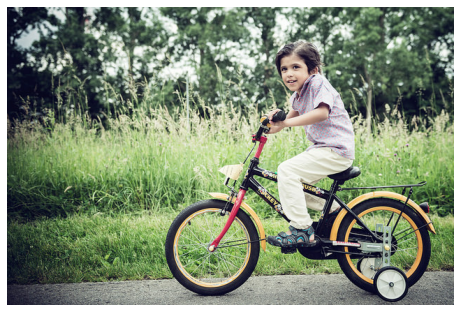

In [ ]:
// Load the hipster cat!
let _URL = "https://github.com/diwakar-vsingh/DeepLabV3-TensorFlow2.x/blob/master/Images/image1.jpg?raw=true"
downloadFile(from: _URL, to: "image1.jpg")
let image = loadJpegAsTensor(from: "image1.jpg")

print(image.shape)
show_img(image)

## Make Predictions

In [ ]:
func Inference(of image: Tensor<Float>) -> (Tensor<Float>, Tensor<Int32>) {
  let (height, width): (Int, Int) = (image.shape[0], image.shape[1])
  let resized_image = tf.image.resize(image.makeNumpyArray(), size: [INPUT_SIZE, INPUT_SIZE], 
    preserve_aspect_ratio: Python.True, antialias: Python.True)
  let resizedImage = Tensor<Float>(numpy: resized_image.numpy())!

  let padH = INPUT_SIZE - resizedImage.shape[0]
  let padW = INPUT_SIZE - resizedImage.shape[1]
  let padding = [(before: 0, after: padH),
                 (before: 0, after: padW),
                 (before: 0, after: 0)]

  var normImage = resizedImage.padded(forSizes: padding, mode: .constant(0.0))
  normImage = (normImage / 0.5) - 1
  normImage = normImage.expandingShape(at: 0)
  
  let logit = deepLab.inferring(from: normImage)
  var segMap = logit[0].argmax(squeezingAxis: -1)
  segMap = segMap.slice(lowerBounds: [0, 0], upperBounds: [INPUT_SIZE - padH, INPUT_SIZE - padW])
  
  return (resizedImage, segMap)
}

## Dispaly Segmentation Mask

In [ ]:
func segmentationOverlay(of img: Tensor<Float>, with seg: Tensor<Int32>, _ w: Int = 15, _ h: Int = 10) {
    plt.figure(figsize: [w, h])
    plt.subplot(121)
    plt.imshow(img.makeNumpyArray())
    plt.axis("off")
    plt.title("Input Image")

    plt.subplot(122)
    plt.imshow(img.makeNumpyArray())
    plt.imshow(seg.makeNumpyArray(), alpha: 0.7)
    plt.axis("off")
    plt.title("Segmentation Overlay")
    plt.show()
}

In [ ]:
let (resizedImage, segMap) = Inference(of: image)
segmentationOverlay(of: resizedImage, with: segMap)